In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# **Load Data with AQI**

In [3]:
# Load processed data with AQI
df = pd.read_csv('/content/aqi_data.csv')
df.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,timestamp,temperature_2m,relative_humidity_2m,surface_pressure,...,latitude,longitude,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co,aqi,aqi_category
0,108.3,107.1,941.0,73.9,17.6,14.0,2024-12-24 00:00:00,7.7,80,953.9,...,33.6996,73.0362,178,77,13,72,25,9,178,Unhealthy
1,98.3,97.1,754.0,58.8,15.7,27.0,2024-12-24 01:00:00,7.9,78,953.3,...,33.6996,73.0362,172,72,25,56,22,7,172,Unhealthy
2,92.4,91.3,618.0,45.4,14.3,38.0,2024-12-24 02:00:00,7.7,78,953.1,...,33.6996,73.0362,169,70,35,43,20,6,169,Unhealthy
3,87.5,86.6,514.0,33.2,13.6,46.0,2024-12-24 03:00:00,7.4,77,952.8,...,33.6996,73.0362,167,67,43,31,19,5,167,Unhealthy
4,83.1,82.2,461.0,22.8,13.4,52.0,2024-12-24 04:00:00,7.2,77,952.3,...,33.6996,73.0362,165,65,48,22,19,5,165,Unhealthy


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# **Correlation with AQI (Target)**

In [7]:
numeric_df = df.select_dtypes(include=np.number)
correlations = numeric_df.corr()['aqi'].sort_values(ascending=False)
print("Correlation with AQI:")
print(correlations)

Correlation with AQI:
aqi                     1.000000
aqi_o3                  0.698823
ozone                   0.638278
temperature_2m          0.439289
aqi_pm10                0.396757
sulphur_dioxide         0.319438
aqi_so2                 0.288552
pm10                    0.182744
wind_speed_10m          0.131395
aqi_no2                 0.074860
pm2_5                   0.019733
aqi_pm25                0.015580
cloud_cover             0.006990
precipitation          -0.020561
wind_direction_10m     -0.080365
surface_pressure       -0.122397
carbon_monoxide        -0.144826
aqi_co                 -0.145321
relative_humidity_2m   -0.283485
nitrogen_dioxide       -0.310064
latitude                     NaN
longitude                    NaN
Name: aqi, dtype: float64


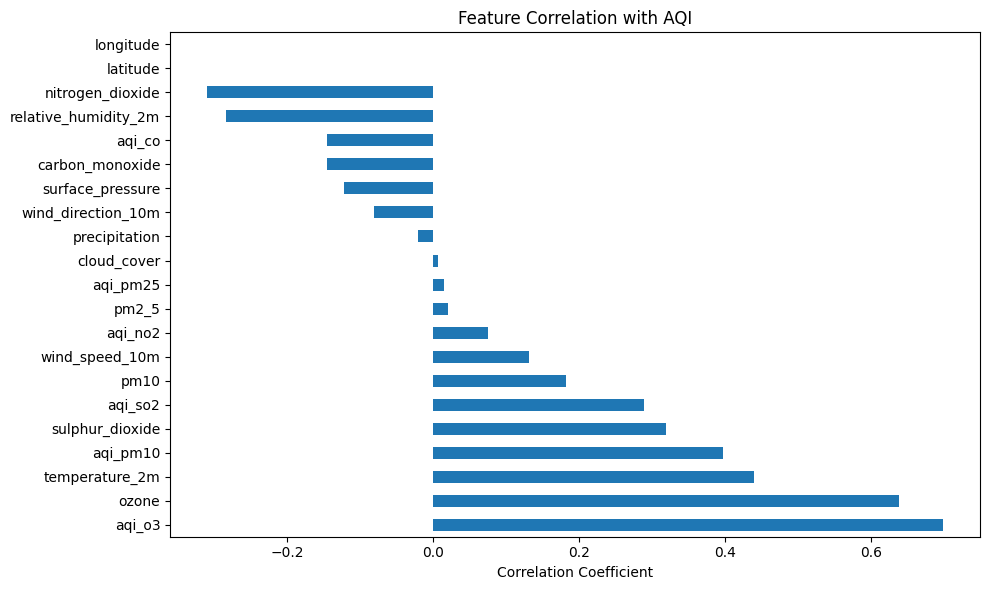

In [8]:
# Visualize
plt.figure(figsize=(10, 6))
correlations.drop('aqi').plot(kind='barh')
plt.title('Feature Correlation with AQI')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# **Feature Importance (Random Forest)**

In [10]:

# Prepare features (exclude AQI and non-predictive columns)
exclude_cols = ['timestamp', 'aqi', 'aqi_category', 'city', 'latitude', 'longitude',
                'aqi_pm25', 'aqi_pm10', 'aqi_o3', 'aqi_no2', 'aqi_so2', 'aqi_co']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['aqi']

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)


RandomForestRegressor(random_state=42)

In [11]:
# Get feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance)




Feature Importance:
                 feature  importance
5                  ozone    0.632188
0                   pm10    0.181831
3       nitrogen_dioxide    0.056067
1                  pm2_5    0.034561
4        sulphur_dioxide    0.024134
2        carbon_monoxide    0.015816
7   relative_humidity_2m    0.011306
10    wind_direction_10m    0.010761
9         wind_speed_10m    0.010158
6         temperature_2m    0.010157
8       surface_pressure    0.008350
12           cloud_cover    0.003101
11         precipitation    0.001569


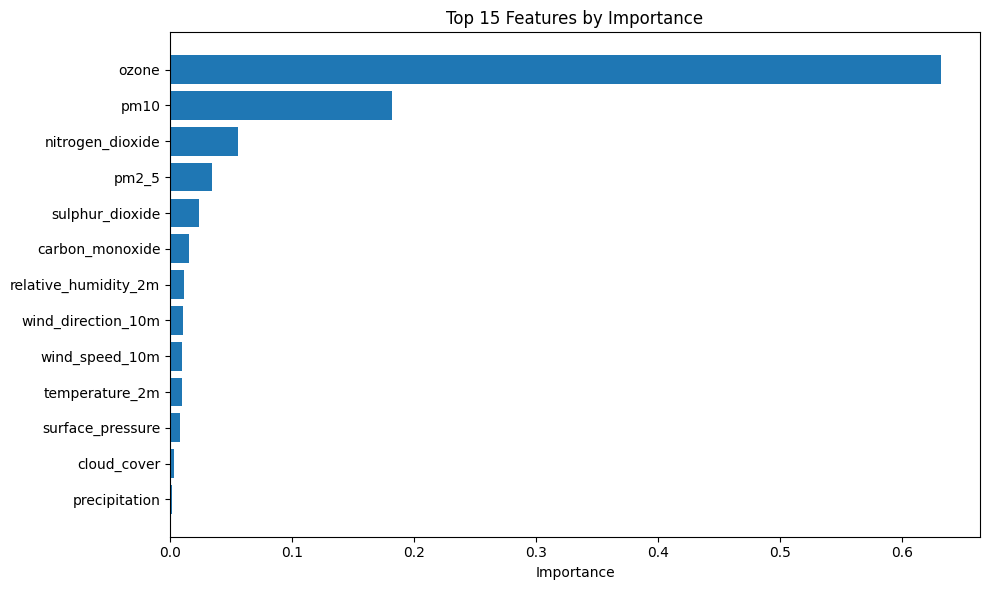

In [12]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'][:15], importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Features by Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# **Check Multicollinearity (VIF)**

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = feature_cols
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(feature_cols))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factor (VIF):")
print(vif_data)
print("\nNote: VIF > 10 indicates high multicollinearity")


Variance Inflation Factor (VIF):
                 feature        VIF
8       surface_pressure  53.071606
5                  ozone  29.872930
1                  pm2_5  26.694931
6         temperature_2m  23.705417
3       nitrogen_dioxide  20.762981
7   relative_humidity_2m  12.483563
0                   pm10  11.640242
4        sulphur_dioxide  10.922637
2        carbon_monoxide   5.897224
9         wind_speed_10m   5.072969
10    wind_direction_10m   4.894720
12           cloud_cover   1.848882
11         precipitation   1.193589

Note: VIF > 10 indicates high multicollinearity


# **Analyze Findings**

In [14]:
# Summary of findings
print("\n=== FEATURE SELECTION SUMMARY ===")
print(f"\nTotal features available: {len(feature_cols)}")
print(f"\nHighly correlated with AQI (|corr| > 0.5):")
high_corr = correlations[abs(correlations) > 0.5].drop('aqi')
print(high_corr)

print(f"\nTop 10 important features:")
print(importance.head(10))

print(f"\nFeatures with high multicollinearity (VIF > 10):")
print(vif_data[vif_data['VIF'] > 10])


=== FEATURE SELECTION SUMMARY ===

Total features available: 13

Highly correlated with AQI (|corr| > 0.5):
aqi_o3    0.698823
ozone     0.638278
Name: aqi, dtype: float64

Top 10 important features:
                 feature  importance
5                  ozone    0.632188
0                   pm10    0.181831
3       nitrogen_dioxide    0.056067
1                  pm2_5    0.034561
4        sulphur_dioxide    0.024134
2        carbon_monoxide    0.015816
7   relative_humidity_2m    0.011306
10    wind_direction_10m    0.010761
9         wind_speed_10m    0.010158
6         temperature_2m    0.010157

Features with high multicollinearity (VIF > 10):
                feature        VIF
8      surface_pressure  53.071606
5                 ozone  29.872930
1                 pm2_5  26.694931
6        temperature_2m  23.705417
3      nitrogen_dioxide  20.762981
7  relative_humidity_2m  12.483563
0                  pm10  11.640242
4       sulphur_dioxide  10.922637
